In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import re
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16, resnet50

from glob import glob
from ffpyplayer.player import MediaPlayer

%matplotlib inline

In [2]:
# create glob object for both train and test directories
train_img_glob = glob('data/train/*/*.jpg')
test_img_glob = glob('data/test/*/*.jpg')

# train and test directories
base = os.path.dirname('')
TRAIN_DIR = os.path.join(base + 'data/train')
TEST_DIR = os.path.join(base + 'data/test')

# initiate model and weights for extracting faces
prototxt_file = os.path.join(base + 'data/deploy.prototxt.txt')
caffemodel_file = os.path.join(base + 'data/weights.caffemodel')

In [3]:
# count total images from both directories
total = len(train_img_glob) + len(test_img_glob)
percent_train = int(len(train_img_glob)/total * 100)
percent_test = int(len(test_img_glob)/total * 100)

print("Total images:", total)
print("Total number of training images before preprocessing:", len(train_img_glob), "(", percent_train, "%)")
print("Total number of training images before preprocessing:", len(test_img_glob), "(", percent_test, "%)")

Total images: 1810
Total number of training images before preprocessing: 1480 ( 81 %)
Total number of training images before preprocessing: 330 ( 18 %)


In [8]:
# use cv2 built-in method cv2.dnn.readNetFromCaffe to extract faces
face_model = cv2.dnn.readNetFromCaffe(prototxt_file, caffemodel_file)

In [9]:
CONFIDENCE = 0.5
IMG_SIZE = 224
ONE_HOT_LABEL = {'dahyun':0, 'juri':1, 'sohee':2, 'suyun':3, 'yeonhee':4, 'yunkyoung':5}
train_extracted_faces = []
test_extracted_faces = []
names = []
train_skipped = 0

# training image
for img in train_img_glob:
    # read in the image
    a = cv2.imread(img)
    (h,w) = a.shape[:2]
    # create a blob object
    blob = cv2.dnn.blobFromImage(a, scalefactor=1.0, size=(IMG_SIZE, IMG_SIZE), 
                                 mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
    face_model.setInput(blob)
    # detect face
    detector = face_model.forward() 
    
    # if any face is detected
    if len(detector) > 0:
        # get the index of the face
        i = np.argmax(detector[0,0,:,2])
        confidence = detector[0,0,i,2]
        
        # if the confidence is higher than the threshold we set earlier
        if confidence > CONFIDENCE:
            # extract face from a rectangle
            rect = detector[0,0,i,3:7] * np.array([w,h,w,h])
            start_x, start_y, end_x, end_y = rect.astype('int')
            
            face = a[start_y:end_y, start_x:end_x]
            
            # skip it if there is no face
            if face.size == 0:
                print('Skipping...')
                print('No face detected:', img)
                train_skipped += 1
                continue
            
            # resize the face
            face = cv2.resize(face, (IMG_SIZE,IMG_SIZE))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            cv2.rectangle(a, (start_x, start_y), (end_x, end_y), (255,255,255), 2)
            
            train_extracted_faces.append(face)
        
        # skip otherwise
        else:
            print('Skipping...')
            print('Confidence below threshold:', img)
            train_skipped += 1
            continue
    
    # give the label according to the correct image using regex
    label = re.findall('\\\\[a-z].*\\\\', img)[0]
    label = label[1:-1]
    
    names.append(ONE_HOT_LABEL[label])
    
# save to disk
train_pickle = {'extracted_faces': train_extracted_faces, 'names': names}
with open('train_extracted_faces.pickle', 'wb') as f:
    pickle.dump(train_pickle, f)

Skipping...
No face detected: data/train\dahyun\RCPC_members-1209682000044445697-20191225_104718-img3.jpg
Skipping...
No face detected: data/train\dahyun\RCPC_members-1235880708607885312-20200306_175137-img1.jpg
Skipping...
Confidence below threshold: data/train\dahyun\RCPC_members-1235880708607885312-20200306_175137-img2.jpg
Skipping...
Confidence below threshold: data/train\dahyun\RCPC_members-1259693901591408642-20200511_105644-img1.jpg
Skipping...
Confidence below threshold: data/train\dahyun\RCPC_members-1259693901591408642-20200511_105644-img2.jpg
Skipping...
Confidence below threshold: data/train\dahyun\RCPC_members-1274210773338710017-20200620_122136-img4.jpg
Skipping...
No face detected: data/train\dahyun\RCPC_members-1278613608243449856-20200702_155654-img3.jpg
Skipping...
Confidence below threshold: data/train\dahyun\RCPC_members-1309423017290641408-20200925_162229-img2.jpg
Skipping...
Confidence below threshold: data/train\juri\RCPC_members-1194528907459850240-20191113_1514

Skipping...
Confidence below threshold: data/train\yeonhee\RCPC_members-1290870909809516545-20200805_114302-img2.jpg
Skipping...
Confidence below threshold: data/train\yeonhee\RCPC_members-1291747270426112000-20200807_214523-img1.jpg
Skipping...
Confidence below threshold: data/train\yeonhee\RCPC_members-1294613030089551873-20200815_193253-img3.jpg
Skipping...
No face detected: data/train\yeonhee\RCPC_members-1295704768950571008-20200818_195104-img1.jpg
Skipping...
Confidence below threshold: data/train\yeonhee\RCPC_members-1296761770292310021-20200821_175113-img1.jpg
Skipping...
Confidence below threshold: data/train\yeonhee\RCPC_members-1296761770292310021-20200821_175113-img4.jpg
Skipping...
Confidence below threshold: data/train\yeonhee\RCPC_members-1298600891415588864-20200826_193914-img2.jpg
Skipping...
Confidence below threshold: data/train\yeonhee\RCPC_members-1298600891415588864-20200826_193914-img3.jpg
Skipping...
No face detected: data/train\yeonhee\RCPC_members-129962554973

In [10]:
CONFIDENCE = 0.5
IMG_SIZE = 224
ONE_HOT_LABEL = {'dahyun':0, 'juri':1, 'sohee':2, 'suyun':3, 'yeonhee':4, 'yunkyoung':5}
test_extracted_faces = []
names = []
test_skipped = 0

# training image
for img in test_img_glob:
    a = cv2.imread(img)
    (h,w) = a.shape[:2]
    blob = cv2.dnn.blobFromImage(a, scalefactor=1.0, size=(IMG_SIZE, IMG_SIZE), 
                                 mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
    face_model.setInput(blob)
    detector = face_model.forward()
    
    if len(detector) > 0:
        i = np.argmax(detector[0,0,:,2])
        confidence = detector[0,0,i,2]
        
        if confidence > CONFIDENCE:
            rect = detector[0,0,i,3:7] * np.array([w,h,w,h])
            start_x, start_y, end_x, end_y = rect.astype('int')
            
            face = a[start_y:end_y, start_x:end_x]
            
            if face.size == 0:
                print('Skipping...')
                print('No face detected:', img)
                test_skipped += 1
                continue
                
            face = cv2.resize(face, (IMG_SIZE,IMG_SIZE))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            cv2.rectangle(a, (start_x, start_y), (end_x, end_y), (255,255,255), 2)
            
            test_extracted_faces.append(face)
        
        else:
            print('Skipping...')
            print('Confidence below threshold:', img)
            test_skipped += 1
            continue
    
    label = re.findall('\\\\[a-z].*\\\\', img)[0]
    label = label[1:-1]
    
    names.append(ONE_HOT_LABEL[label])
    
# save to disk
test_pickle = {'extracted_faces': test_extracted_faces, 'names': names}

with open('test_extracted_faces.pickle', 'wb') as f:
    pickle.dump(test_pickle, f)

Skipping...
Confidence below threshold: data/test\dahyun\RCPC_members-1205115119753023488-20191212_202009-img1.jpg
Skipping...
Confidence below threshold: data/test\dahyun\RCPC_members-1232620519469400064-20200226_175647-img4.jpg
Skipping...
Confidence below threshold: data/test\juri\RCPC_members-1213385880552886273-20200104_160512-img1.jpg
Skipping...
Confidence below threshold: data/test\juri\RCPC_members-1213385880552886273-20200104_160512-img2.jpg
Skipping...
Confidence below threshold: data/test\juri\RCPC_members-1226857875592503298-20200210_201806-img1.jpg
Skipping...
Confidence below threshold: data/test\juri\RCPC_members-1227447059273469960-20200212_111918-img3.jpg
Skipping...
Confidence below threshold: data/test\juri\RCPC_members-1227447059273469960-20200212_111918-img4.jpg
Skipping...
Confidence below threshold: data/test\juri\RCPC_members-1230087961154224129-20200219_181318-img3.jpg
Skipping...
Confidence below threshold: data/test\juri\RCPC_members-1242438394031955969-2020

In [11]:
print("Training images skipped:", train_skipped)
print("Total number of training images after preprocessing:", len(train_extracted_faces))
print("Test images skipped:", test_skipped)
print("Total number of training images after preprocessing:", len(test_extracted_faces))

Training images skipped: 113
Total number of training images after preprocessing: 1367
Test images skipped: 34
Total number of training images after preprocessing: 296


In [ ]:
a = cv2.imread('./data/twitter/RCPC_members-1209747487277215745-20191225_150731-img2.jpg')
(h,w) = a.shape[:2]
blob = cv2.dnn.blobFromImage(a, scalefactor=1.0, size=(224, 224), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
face_model.setInput(blob)
detector = face_model.forward()
    
if len(detector) > 0:
    i = np.argmax(detector[0,0,:,2])
    confidence = detector[0,0,i,2]
        
    if confidence > CONFIDENCE:
        rect = detector[0,0,i,3:7] * np.array([w,h,w,h])
        start_x, start_y, end_x, end_y = rect.astype('int')
            
        face = a[start_y:end_y, start_x:end_x]
        face = cv2.resize(face, (IMG_SIZE,IMG_SIZE))
        cv2.rectangle(a, (start_x, start_y), (end_x, end_y), (255,255,255), 2)
        
        cv2.imshow('face', face)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    else:
        print("no face detected!")
    

In [ ]:
a = cv2.imread('./data/twitter/RCPC_members-1198186468121776128-20191123_172809-img2.jpg')
(h,w) = a.shape[:2]
blob = cv2.dnn.blobFromImage(a, scalefactor=1.0, size=(224, 224), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
face_model.setInput(blob)
detector = face_model.forward()
    
if len(detector) > 0:
    for i in range(0, detector.shape[2]):
        
        rect = detector[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = rect.astype("int")

        confidence = detector[0, 0, i, 2]
        if (confidence > 0.5):
            cv2.rectangle(a, (startX, startY), (endX, endY), (255, 255, 255), 2)
        
    cv2.imshow('multiface detection', a)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
        

## Checkpoint

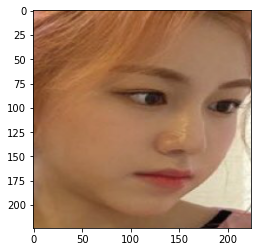

(224, 224, 3)
<class 'numpy.ndarray'>


In [4]:
# load the saved extracted faces pickle
with open('train_extracted_faces.pickle', 'rb') as f:
    train_face_loader = pickle.load(f)

with open('test_extracted_faces.pickle', 'rb') as f:
    test_face_loader = pickle.load(f)
    
raw_train_data = list(train_face_loader.values())
raw_test_data = list(test_face_loader.values())

plt.imshow(raw_train_data[0][1])
plt.show()
print(raw_train_data[0][1].shape)
print(type(raw_train_data[0][1]))

In [5]:
from torchvision import datasets, transforms

root = './data'

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root=root, train=True, transform=transform, download=True)
mnist_val = datasets.MNIST(root=root, train=False, transform=transform, download=True)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=32, num_workers=0, shuffle=True)
mnist_val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=32, num_workers=0, shuffle=True)

In [6]:
print(mnist_train.data.shape)
print(mnist_train.data[0].shape)
print(mnist_train.targets)
print(mnist_train.targets.shape)
print(type(mnist_train.data))

torch.Size([60000, 28, 28])
torch.Size([28, 28])
tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([60000])
<class 'torch.Tensor'>


In [7]:
# split between features and labels
train_features = raw_train_data[0]
train_labels = raw_train_data[1]
test_features = raw_test_data[0]
test_labels = raw_test_data[1]

IMG_SIZE = 224
m = len(train_features)
m_test = len(test_features)
c = 3

x_train = np.asarray(train_features)
x_test = np.asarray(test_features)
x_train_batch_first = x_train.reshape([m,c,IMG_SIZE,IMG_SIZE])
x_test_batch_first = x_test.reshape([m_test,c,IMG_SIZE,IMG_SIZE])
y_train = np.asarray(train_labels)
y_test = np.asarray(test_labels)

print(x_train.shape)
print(x_train_batch_first.shape)
print(y_train.shape)
print(x_test.shape)
print(x_test_batch_first.shape)
print(y_test.shape)

(1367, 224, 224, 3)
(1367, 3, 224, 224)
(1367,)
(296, 224, 224, 3)
(296, 3, 224, 224)
(296,)


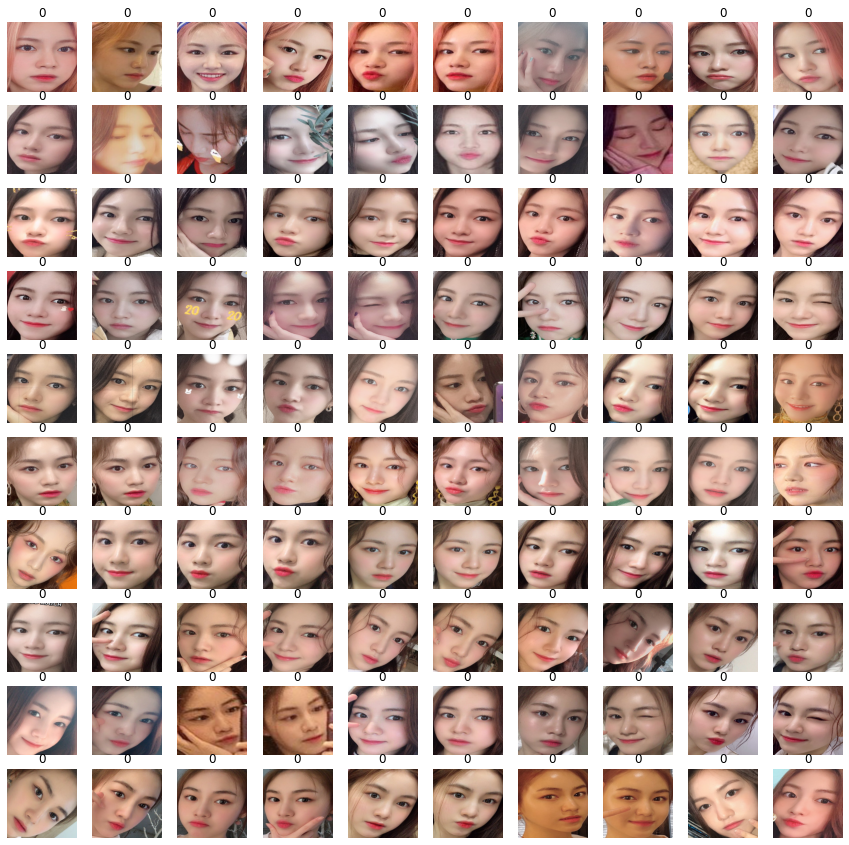

In [8]:
# show all faces for each members
fig, ax = plt.subplots(10, 10, figsize=(15,15))

for (x, y, axi) in zip(train_features, train_labels, ax.flatten()):
#     x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    axi.imshow(x)
    axi.set_title(y)
    
    axi.axis('off')

In [9]:
BATCH_SIZE = 16
NUM_WORKERS = 0

# train_transform = transforms.Compose([transforms.RandomVerticalFlip(0.3),
#                                 transforms.RandomRotation(30),
#                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                                 transforms.ToTensor()])

train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_train_batch_first), torch.from_numpy(y_train))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(x_test_batch_first), torch.from_numpy(y_test))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

In [10]:
# temp_x, temp_y = iter(train_loader).next()
# print(temp_x[0].shape)

# fig, ax = plt.subplots(1, 6, figsize=(12,12))
# for (x, y, axi) in zip(temp_x, temp_y, ax.flatten()):
# #     x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
#     axi.imshow(x)
#     axi.set_title(y)
#     axi.axis('off')

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256*28*28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=6)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 256*28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [16]:
pretrained_model = vgg16(pretrained=True)
pretrained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
for params in pretrained_model.features.parameters():
    params.requires_grad = False
    
last_in_features = pretrained_model.classifier[-1].in_features
pretrained_model.classifier[-1] = nn.Linear(last_in_features, 6)

pretrained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
gpu_availability = torch.cuda.is_available()
model = Model()

if gpu_availability:
    print('Training using GPU:', torch.cuda.get_device_name(0))
    model = model.cuda()
    pretrained_model = pretrained_model.cuda()
else:
    print('Training using CPU')

Training using GPU: GeForce RTX 2070 SUPER


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)
pretrained_optimizer = torch.optim.Adadelta(pretrained_model.parameters(), lr=1e-3, weight_decay=1e-5)

In [16]:
def train(epochs, loaders, model, opt, crit, use_cuda, save_path='vgg16_adadelta_lr1e-3_wd1e-5_epochs100.pt'):
    
    for i in range(epochs):
        training_loss = 0.0
        
        model.train()
        for batch, (data, lbl) in enumerate(loaders):
            data = data.to(torch.float32)
            lbl = lbl.to(torch.long)
            if use_cuda:
                data, lbl = data.cuda(), lbl.cuda()
                
            opt.zero_grad()
            
            output = model(data)
            loss = crit(output, lbl)
            loss.backward()
            opt.step()
            
            training_loss = training_loss + ((1/(batch+1)) * (loss.data - training_loss))
        
        print("Epoch:", i+1, "| Training Loss:", training_loss)
    
    torch.save(model.state_dict(), save_path)
    
    return model

In [17]:
final_model = train(epochs=150, loaders=train_loader, model=pretrained_model, opt=pretrained_optimizer, crit=criterion, use_cuda=gpu_availability)

Epoch: 1 | Training Loss: tensor(5.7024, device='cuda:0')
Epoch: 2 | Training Loss: tensor(4.3706, device='cuda:0')
Epoch: 3 | Training Loss: tensor(3.8517, device='cuda:0')
Epoch: 4 | Training Loss: tensor(3.2279, device='cuda:0')
Epoch: 5 | Training Loss: tensor(3.0034, device='cuda:0')
Epoch: 6 | Training Loss: tensor(2.6353, device='cuda:0')
Epoch: 7 | Training Loss: tensor(2.4532, device='cuda:0')
Epoch: 8 | Training Loss: tensor(2.1992, device='cuda:0')
Epoch: 9 | Training Loss: tensor(2.0487, device='cuda:0')
Epoch: 10 | Training Loss: tensor(1.9407, device='cuda:0')
Epoch: 11 | Training Loss: tensor(1.8804, device='cuda:0')
Epoch: 12 | Training Loss: tensor(1.8298, device='cuda:0')
Epoch: 13 | Training Loss: tensor(1.7846, device='cuda:0')
Epoch: 14 | Training Loss: tensor(1.7412, device='cuda:0')
Epoch: 15 | Training Loss: tensor(1.6801, device='cuda:0')
Epoch: 16 | Training Loss: tensor(1.6504, device='cuda:0')
Epoch: 17 | Training Loss: tensor(1.6651, device='cuda:0')
Epoch:

Epoch: 140 | Training Loss: tensor(0.7223, device='cuda:0')
Epoch: 141 | Training Loss: tensor(0.7039, device='cuda:0')
Epoch: 142 | Training Loss: tensor(0.6813, device='cuda:0')
Epoch: 143 | Training Loss: tensor(0.6994, device='cuda:0')
Epoch: 144 | Training Loss: tensor(0.6642, device='cuda:0')
Epoch: 145 | Training Loss: tensor(0.6710, device='cuda:0')
Epoch: 146 | Training Loss: tensor(0.6605, device='cuda:0')
Epoch: 147 | Training Loss: tensor(0.6585, device='cuda:0')
Epoch: 148 | Training Loss: tensor(0.6588, device='cuda:0')
Epoch: 149 | Training Loss: tensor(0.6623, device='cuda:0')
Epoch: 150 | Training Loss: tensor(0.6462, device='cuda:0')


In [18]:
def evaluate(model, test_loader, use_cuda):
    
    test_loss = 0.0
    correct = 0
    total_data = 0
    
    model.eval()
    for batch_idx, (feature, lbl) in enumerate(test_loader):
        feature = feature.to(torch.float32)
        lbl = lbl.to(torch.long)
        if use_cuda:
            feature, lbl = feature.cuda(), lbl.cuda()
            
        output = model(feature)
        loss = criterion(output, lbl)
        test_loss = test_loss + (1/(batch_idx+1)) * (loss.data - test_loss)
        total_data = total_data + feature.size(0)
        
        pred = output.data.max(1)[1]
        correct += np.sum(np.squeeze(pred.eq(lbl.data.view_as(pred))).cpu().numpy())
        
    print('Test loss: {:.6f}'.format(test_loss))
    print('Test accuracy: {:.2f}%'.format(correct/total_data * 100))

In [19]:
evaluate(final_model, test_loader, gpu_availability)

Test loss: 1.422728
Test accuracy: 47.97%


### Training History

1. 16 October 2020 - 20:17 (Adadelta, lr=1e-3, weight_decay=1e-5, epochs=100)
- Test loss: 1.597817
- Test accuracy: 60.14%

2. 19 October 2020 - 10:43 (VGG16, Adadelta, lr=1e-3, weight_decay=1e-5, epochs=150)
- Test Loss: 1.422728
- Test accuracy: 47.97%

## Checkpoint 2

In [23]:
gpu_availability = torch.cuda.is_available()
model = Model()

if gpu_availability:
    print('Training using GPU:', torch.cuda.get_device_name(0))
    model = model.cuda()
else:
    print('Training using CPU')
    
model.load_state_dict(torch.load('adadelta_lr1e-3_wd1e-5_epochs100.pt'))

Training using GPU: GeForce RTX 2070 SUPER


<All keys matched successfully>

In [24]:
def predict(img_path, model, use_cuda):
    
    IMG_SIZE = 224
    NAMES = ['Dahyun', 'Juri', 'Sohee', 'Suyun', 'Yeonhee', 'Yunkyoung']
    
    test_img = cv2.imread(img_path)
    (h,w) = test_img.shape[:2]
    blob = cv2.dnn.blobFromImage(test_img, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
    face_model = cv2.dnn.readNetFromCaffe(prototxt_file, caffemodel_file)
    face_model.setInput(blob)
    detector = face_model.forward()
    
    if len(detector) > 0:
        for i in range(0, detector.shape[2]):
        
            rect = detector[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = rect.astype("int")

            confidence = detector[0, 0, i, 2]
            if (confidence > 0.5):
                cv2.rectangle(test_img, (startX, startY), (endX, endY), (255, 255, 255), 2)
                
                face = test_img[startY:endY, startX:endX]
                resized_face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
                resized_face = np.expand_dims(resized_face, axis=0)
                print(resized_face.shape)

                m = 1
                c = 3
                resized_face = np.reshape(resized_face, [m, c, IMG_SIZE, IMG_SIZE])
                print(resized_face.shape)

                test_data = torch.Tensor(resized_face)

                model.eval()

                if use_cuda:
                    test_data = test_data.cuda()

                output = model(test_data)
                print(output[0])
                pred = np.argmax(output.cpu().detach())
                print(pred)
                e_x = np.exp(output[0].cpu().detach().numpy())
    
                text = "{}: {:.2f}%".format(NAMES[pred], np.max(e_x/e_x.sum() * 100))
                print(text)
            
                cv2.putText(test_img, text, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
                
    cv2.imshow('Prediction', test_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

In [26]:
predict('./data/twitter/RCPC_members-1266653306794897411-20200530_155056-img1.jpg', model, use_cuda=gpu_availability)

(1, 224, 224, 3)
(1, 3, 224, 224)
tensor([-4.5373,  2.8248,  1.9259,  6.6800,  1.1977, -1.7818], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(3)
Suyun: 96.70%
(1, 224, 224, 3)
(1, 3, 224, 224)
tensor([ 0.7256,  0.4138, -1.9379,  0.8580,  2.0329,  6.7006], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(5)
Yunkyoung: 98.34%
(1, 224, 224, 3)
(1, 3, 224, 224)
tensor([ 0.8257,  0.4549,  1.1051,  0.7259,  7.1331, -0.0961], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(4)
Yeonhee: 99.22%
(1, 224, 224, 3)
(1, 3, 224, 224)
tensor([-2.9296,  1.3016, -1.4285,  0.4376,  3.0092,  0.9968], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(4)
Yeonhee: 71.13%


In [39]:
def predict_from_video(path, model, use_cuda):
    IMG_SIZE = 224
    NAMES = ['Dahyun', 'Juri', 'Sohee', 'Suyun', 'Yeonhee', 'Yunkyoung']
    
    frame_name = 'Video'
    vid = cv2.VideoCapture(path)
    audio = MediaPlayer(path)
    face_model = cv2.dnn.readNetFromCaffe(prototxt_file, caffemodel_file)
    
    cv2.namedWindow(frame_name, cv2.WND_PROP_FULLSCREEN)
    cv2.setWindowProperty(frame_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    fps = vid.get(cv2.CAP_PROP_FPS)
    print('Video fps:', fps)
    
    while vid.isOpened():
        ret, frame = vid.read()
        (h,w) = frame.shape[:2]
        audio_frame, val = audio.get_frame()
        
        blob = cv2.dnn.blobFromImage(frame, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
        face_model.setInput(blob)
        detector = face_model.forward()
        
        if len(detector) > 0:
            for i in range(0, detector.shape[2]):
                rect = detector[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = rect.astype("int")

                confidence = detector[0, 0, i, 2]
                if (confidence > 0.5):
                    cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 255, 255), 2)

                    face = frame[startY:endY, startX:endX]
                    if face.size == 0:
                        continue
                        
                    resized_face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
                    resized_face = np.expand_dims(resized_face, axis=0)

                    m = 1
                    c = 3
                    resized_face = np.reshape(resized_face, [m, c, IMG_SIZE, IMG_SIZE])
                    test_data = torch.Tensor(resized_face)

                    model.eval()
                    if use_cuda:
                        test_data = test_data.cuda()

                    output = model(test_data)
                    pred = np.argmax(output.cpu().detach())
                    e_x = np.exp(output[0].cpu().detach().numpy())

                    text = "{}: {:.2f}%".format(NAMES[pred], np.max(e_x/e_x.sum() * 100))
                    cv2.putText(frame, text, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        
        if not ret:
            print('End of video...')
            break
            
        cv2.imshow(frame_name, frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        if val != 'eof' and audio_frame is not None:
            img, t = audio_frame
        
    vid.release()
    cv2.destroyAllWindows()

In [40]:
predict_from_video('data/videos/rcpc_loveisover_mcountdown.webm', model, gpu_availability)

Video fps: 29.97002997002997
